In [ ]:
import glob
from func import *
import pandas as pd
import csv
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests
import sys 
sys.path.append("..") 
sys.path.append("../scripts")
from scripts import process_ptb, process_ctb
from utils import *
# from scripts import process_ptb, process_ctb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 


# Response Process
The results of meaningless sentences can be directly processed, without annotations of treebanks.

But you can also replicate our results by using our processed data, which can be directly used in the **Visualization** section.

In [ ]:

parsed_file = pd.read_csv('stimulus/constituency_tree.csv',
            delimiter='\t',
            quoting=csv.QUOTE_NONE,
            quotechar=None)
sentence = parsed_file['sentence'].values.tolist()
parsed = parsed_file['tree'].values.tolist()
en_parsed_lst = []
zh_parsed_lst = []
for sent, tree in zip(sentence, parsed):
    if len(re.findall('[^\u4e00-\u9fa5]', sent)) != 0:
        en_parsed_lst.append([sent, tree])
    else:
        zh_parsed_lst.append([sent, tree])
en_cons_feature_dict, _ = process_ptb.get_cons_feature(en_parsed_lst)
cons_feature_dict, _ = process_ctb.get_cons_feature(zh_parsed_lst)
cons_feature_dict.update(en_cons_feature_dict)

## ChatGPT

In [ ]:
# English

total_result_en = []
paths = glob.glob(f"result/english/*.csv")
for p in paths:
    result = []
    resp_file = pd.read_csv(p,
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    for idx, row in resp_file.iterrows():
        result.append(row.tolist())
    total_result_en.append(result)


# Chinese

total_result_zh = []
paths = glob.glob(f"result/chinese/*.csv")
for p in paths:
    result = []
    resp_file = pd.read_csv(p,
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    for idx, row in resp_file.iterrows():
        result.append(row.tolist())
    total_result_zh.append(result)

total_phrase = []
for result in total_result_en:
    
    phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict)
    total_phrase.append(phrase_sent)

for result in total_result_zh:
    phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict)
    total_phrase.append(phrase_sent)
    


total_node = []

total_parent = []

for phrase_sent in total_phrase:
    node_lst = []
    parent_lst = []

    for phrase_item in phrase_sent:
        if ' ' in phrase_item[0]:
            if len(phrase_item[0].split(' ')) - len(phrase_item[1].split(' ')) == 1:
                continue
        else:
            if len(list(phrase_item[0])) - len(list(phrase_item[1])) == 1:
                continue
        cons_feature = cons_feature_dict[phrase_item[0]]
        for test_label_cons in phrase_item[2]:
            node = test_label_cons.split('-')[0]
            parent = cons_feature[5][test_label_cons][-1].split('-')[0]
            node_lst.append(node)
            parent_lst.append(parent)
    total_node.append(node_lst)
    total_parent.append(parent_lst)

node_explained = []
parent_explained = []
for node_lst, parent_lst in zip(total_node, total_parent):
    node_rate = 0
    parent_rate = 0
    for node, parent in zip(node_lst, parent_lst):
        if node == 'NP' and parent == 'VP':
            continue
        if node == 'NP':
            node_rate+=1
        if parent == 'VP':
            parent_rate += 1
    node_explained.append(node_rate / len(node_lst))
    parent_explained.append(parent_rate / len(parent_lst))




# Visualization

## Constituent rate

/tmp/ipykernel_473223/1162069730.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax,


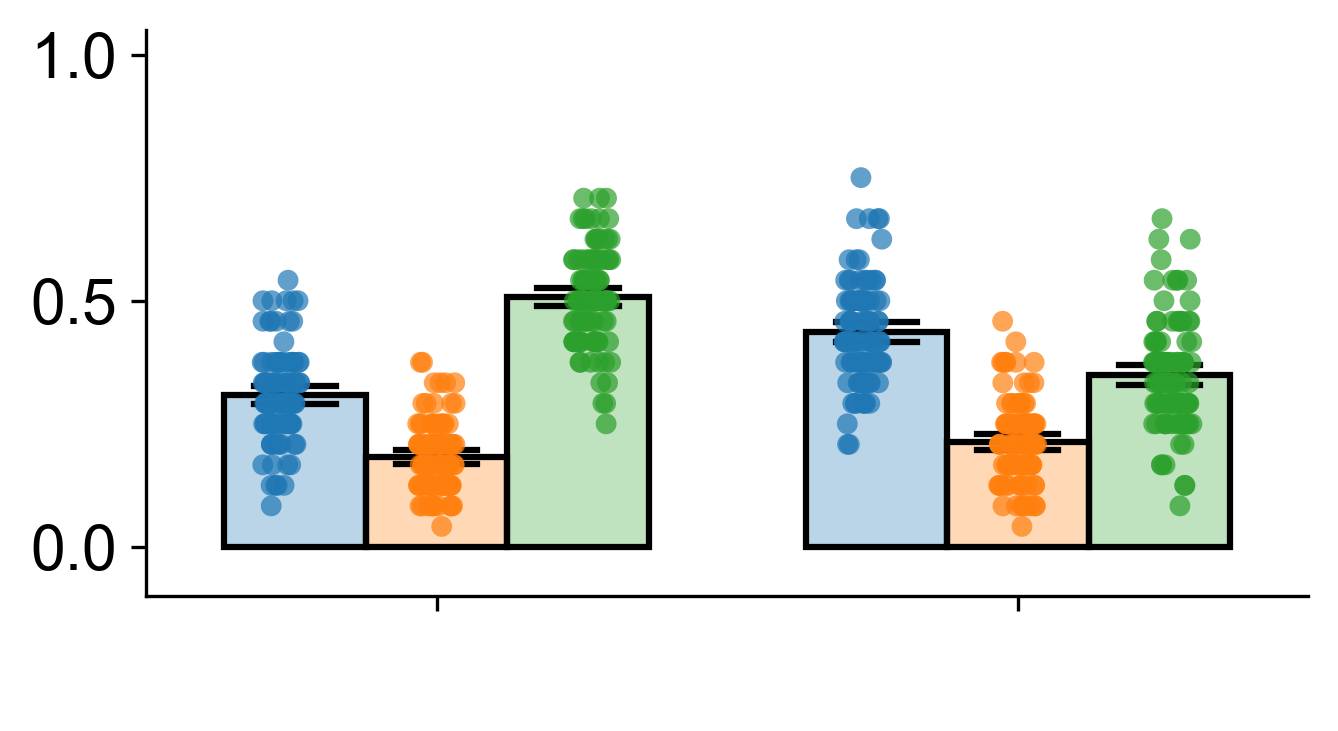

In [3]:
plt.rcParams['font.size'] = 15


sns.set_context(rc = {'patch.linewidth': 1.5})


fig, ax = plt.subplots(1, 1 , figsize=(5,2.5))

df = read_pkl("processed_data/constituent_rate.pkl")[0]

palette = {
    'phrase': '#1f77b4',
    'word': '#ff7f0e',
    'other': '#d62728',
    'fail': '#2ca02c'
}


g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax, 
                palette=palette,
                errorbar = ('ci', 95),  
                estimator=np.mean, ci=95, capsize=.14, 
                errwidth=1.5, errcolor = 'k', 
                edgecolor =  (0,0,0,1), width=0.73
                )
hue_nums = df.groupby("class")["type"].nunique().values

color_lst = ['#1f77b4',
    '#ff7f0e',
    
    '#2ca02c',
    '#d62728',]


for i, bar in enumerate(g.patches):
    if i == sum(hue_nums):
        break
    x_category = np.repeat(np.arange(max(hue_nums)), len(hue_nums))[i]
    hue_category = np.tile(np.arange(max(hue_nums)), len(hue_nums))[i]
    color = color_lst[x_category]
    bar.set_facecolor(to_rgba(color, 0.3))
    bar.set_edgecolor((0, 0, 0, 1))
    

g = sns.stripplot(
    data = df,
    x="class", 
    y="value", 
    hue="type", 
    dodge=True, 
    alpha=0.7,
    edgecolor=None, 
    ax=ax
)

plt.ylim([-0.0,1.05])
sns.despine(top=True, right=True, left=False, bottom=False)
g.set(ylabel='')
g.set(xlabel='  ')

g.set(ylim=[-0.1,1.05])
g.set(ylabel='Proportion')
g.set(xlabel='  ')
g.set(xticklabels=[])

hatches = ['', '', '', '']*3

for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])

plt.ylabel("")
plt.xlabel(r"   ")

plt.legend([],[], frameon=False)


## Explained ratio

model-en significance test:  0.00019998000199980003
model-zh significance test:  0.00019998000199980003
model-en significance test:  0.00019998000199980003
model-zh significance test:  0.00019998000199980003


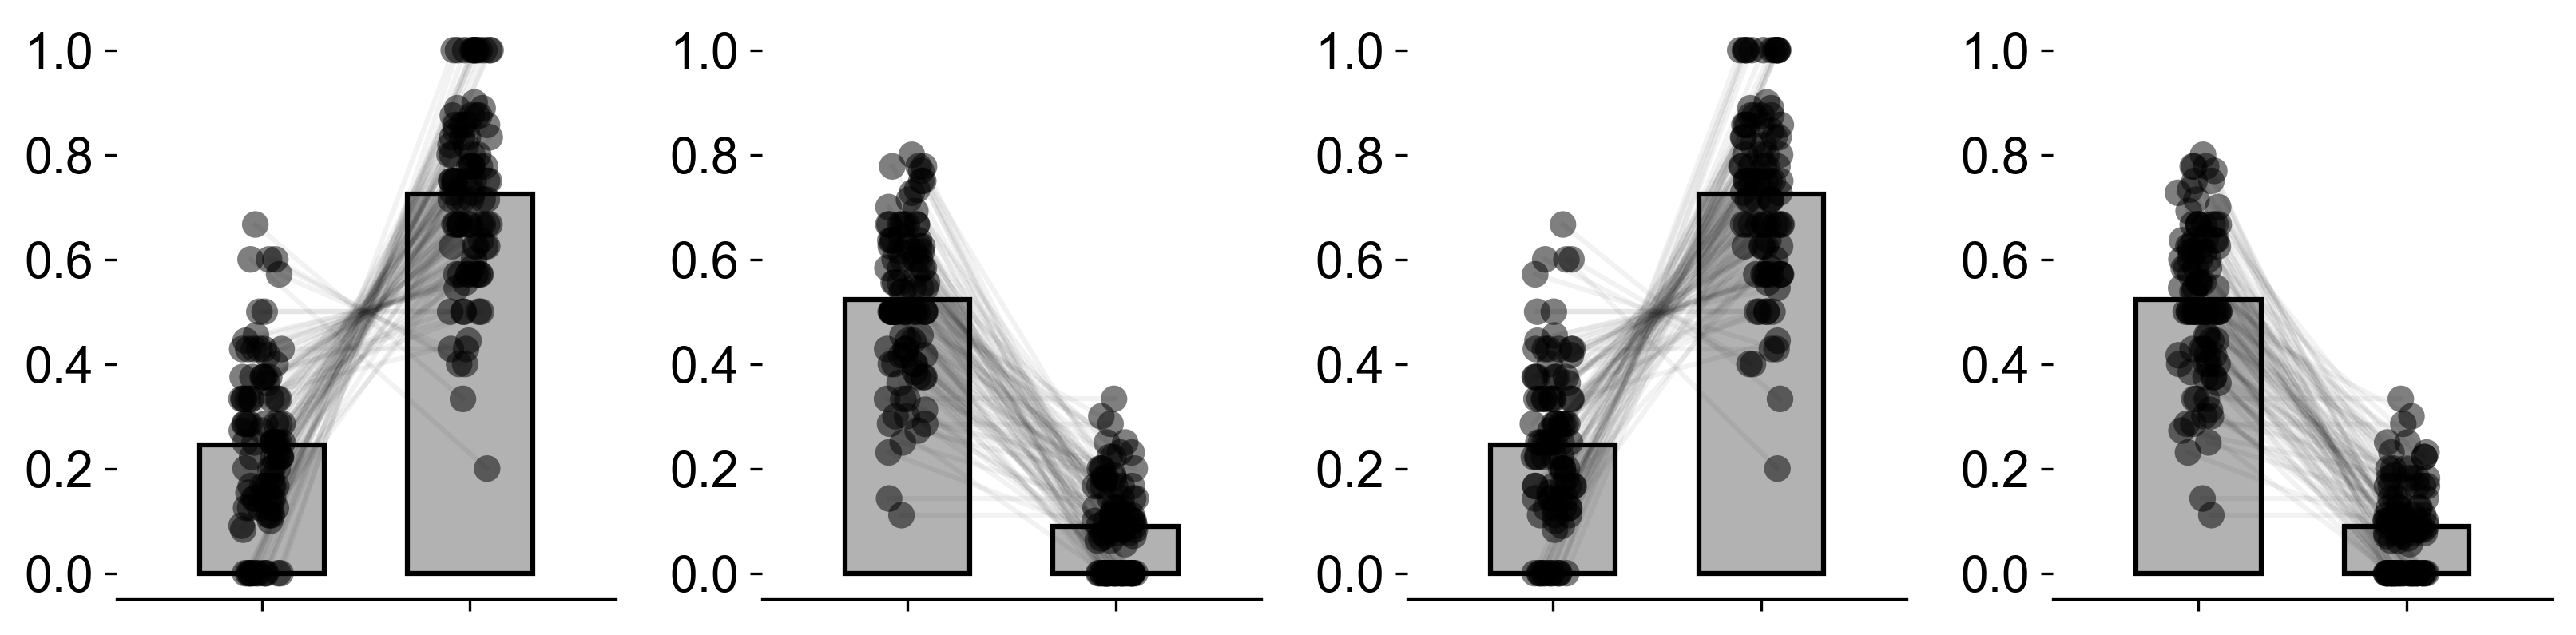

In [4]:
df = read_pkl('processed_data/explained_ratio.pkl')

fig, axes = plt.subplots(1,4, figsize=(11,2.9))
sns.despine(top=True, right=True, left=True, bottom=False)

pvals =[]
model_lst = ['model-en', 'model-zh']*2
for ax, prefix in zip(axes, model_lst,):
    plot_df = df[df.iloc[:,0].str.contains(prefix + '_')]
    palette = {
        'model-en': 'k',
        'model-zh': 'k',
    }
    color = palette[prefix]
    g = sns.barplot(data = plot_df, x='subj', y='value', ax=ax, 
                    color=color,
                    errorbar = None,  
                    capsize=.1, 
                    width=0.6,
                    edgecolor = (0,0,0,1),
                    )
    for i, bar in enumerate(g.patches):
        color = color
        bar.set_facecolor(to_rgba(color, 0.3))
        bar.set_edgecolor((0, 0, 0, 1))
    g = sns.stripplot(data=plot_df, x='subj', y='value', ax=ax, 
                      size=8, color=color, edgecolor=None, alpha=0.5)

    a = ax.scatter([1,2],[3,4], marker='o')
    b = ax.scatter([1,2],[3,4], marker='o')
    square_mk, = a.get_paths()
    triangle_up_mk, = b.get_paths()
    a.remove()
    b.remove()
    N_hues = len(pd.unique(plot_df.subj))

    c = ax.collections
    for a in c[::N_hues]:
        a.set_paths([triangle_up_mk])
    for a in c[1::N_hues]:
        a.set_paths([square_mk])
    ax.legend(c[-2:],pd.unique(plot_df.subj))


    set1 = plot_df[plot_df['subj'] == prefix+'_node']['value'].tolist()
    set2 = plot_df[plot_df['subj'] == prefix+'_parent']['value'].tolist()
    print(prefix, "significance test: ", paired_bootstrap_test(set1, set2))

    idx0 = 2
    idx1 = 3
    locs1 = ax.get_children()[idx0].get_offsets()
    locs2 = ax.get_children()[idx1].get_offsets()

    sort_idxs1 = np.argsort(set1)
    sort_idxs2 = np.argsort(set2)

    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    locs2_sorted = locs2

    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2_sorted[i, 0]]
        y = [locs1[i, 1], locs2_sorted[i, 1]]
        ax.plot(x, y, color=color, alpha=0.05)
    g.set(xlim=[-0.7,1.7])
    g.set(ylim=[-0.05, 1.05])
    g.set(yticks=[0.0,0.2,0.4,0.6,0.8,1.0])

    g.set(ylabel='')
    g.set(xlabel='')
    g.set(xticklabels='')

    ax.legend([],[], frameon=False)
plt.tight_layout()
